In [232]:
from bertopic import BERTopic
import pandas as pd
import nltk
import numpy as np
import re
import os
import string
import spacy
import torch
from bertopic import BERTopic
from collections import Counter
from nltk.corpus import stopwords
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline
from flair.embeddings import TransformerWordEmbeddings
from flair.embeddings import TransformerDocumentEmbeddings
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df_grk = pd.read_csv(r"C:\Users\samer\Documents\university\scraped.csv")
texts_ = df_grk.text.tolist()[:200]
df_grk.head(2)

In [140]:
len(texts_)

1000

## creat embeddings

In [39]:
pre_trained_bert = BertModel.from_pretrained("bert-base-german-cased")
tokenizer_gottbert = BertTokenizer.from_pretrained("bert-base-german-cased")

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [92]:
tokenized_texts = tokenizer_gottbert(texts_, truncation=True, padding=True)

In [74]:
pre_trained_bert.eval()
print("evaluation mode")

evaluation mode


In [ ]:
tokens_tensor = torch.tensor(tokenized_texts['input_ids'])
segments_tensors = torch.tensor(tokenized_texts['attention_mask'])

total_embeddings = []
for input_id_ , segment_tensor_ in zip(tokens_tensor,segments_tensors):


    # Predict hidden states features for each layer
    with torch.no_grad():
        output = pre_trained_bert(input_id_.unsqueeze(0), segment_tensor_.unsqueeze(0))

    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddings = torch.stack(tuple(output[0]), dim=0)

    # Remove dimension 1, the "batches".
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(1,0,2)

    total_embeddings.append(token_embeddings)

In [138]:
### sentence vector:
sentence_embeddings = []
for embedidng_ in total_embeddings:
    
    sentence_embedding = torch.mean(embedidng_, dim=0)
    
    sentence_embeddings.append(sentence_embedding.detach().numpy()[0])

sentence_embeddings = np.asarray(sentence_embeddings)

# use Bertopic

In [143]:
topic_model = BERTopic()                                              # the text embeddings
topics, probs = topic_model.fit_transform('TEXT YOU EMBEDDED ORIGINAL', sentence_embeddings)


In [155]:
def get_similar_text_by_Bert_top_cluster(texts, topic_num):
    topic_num_1 = [idx for idx, i in enumerate(list(topic_model.topics_)) if i==top_num]
    top_1_texts = map(texts.__getitem__, topic_num_1)
    top_1_texts = list(top_1_texts)
    return top_1_texts

get_similar_text_by_Bert_top_cluster(texts_, 2)

In [228]:
def get_similar_documents(sentence_embeddings,n_doc, source_sentence_idx=None):
    
    if(source_sentence_idx == None):
        raise Exception("you must set source_sentence_idx to index of text you want to examine")
    
    indices_list = []
    similarity_values = []
    for i in range(len(sentence_embeddings)):
        if(i == source_sentence_idx):
            continue
        val_ = cosine_similarity([sentence_embeddings[source_sentence_idx]], [sentence_embeddings[i]])[0][0]
        
        indices_list.append(i)
        similarity_values.append(val_)
    
    df_temp = pd.DataFrame(similarity_values, index=indices_list, columns=["cosine_values"])
    df_temp = df_temp.sort_values("cosine_values", ascending=False)
    return df_temp.head(n_doc)
    

In [234]:
df_temp = get_similar_documents(np.asarray(sentence_embeddings),10, 4)

## the cosine value is "the distance" between two texts,
## the index number, refers to index in the text list, which holds the text similar to pur source text
df_temp

,cosine_values
200,0.963634
922,0.939800
483,0.937079
20,0.936949
342,0.936091
933,0.936091
498,0.933694
926,0.933622
635,0.933205
515,0.931992


#### with cosine similar, it linked the 4th text in text_ as the most similar to text 200
#### as we see both are about the same topic, which is erste hilfe Ausbildung/Fortbildung

In [225]:
texts_[4]

'Diese Ausbildung wird gemäß der Unfallverhütungsvorschrift "Erste Hilfe" (BGV-A1) durchgeführt und umfasst einen Tag 9 Unterrichtsstunden (UE) a 45 Minuten.\n\nDie Erste Hilfe Grundausbildung wird anerkannt für:\n\nDie Kosten für die Ersthelferausbildung in Firmen übernimmt grundsätzlich die zuständige Berufsgenossenschaft oder Unfallkasse.\n\nFür die unbedingte Anmeldung und Rückfragen stehen Ihnen die Mitarbeiter im Rot Kreuz Zentrum (Geschäftsstelle) unter (03663) 421124 ; (03663) 421125 oder (03663) 42110 zur Verfügung.'

In [231]:
texts_[200]

'Leben retten muss man üben!\n\nIn diesem Lehrgang können Sie Ihre Erste Hilfe Kenntnisse auffrischen. \n\nNur so sind Sie fit für den Notfall.\n\nDieser Lehrgang gilt als Fortbildungslehrgang für betriebliche Ersthelfer (BGV A1§). Voraussetzung ist die Absolvierung einer Grundausbildung in Erster-Hilfe (9 Unterrichtsstunden).\n\nAber auch alle, die mal wieder ihre Erste Hilfe Kenntnisse auffrischen wollen, sind herzlich willkommen.\n\nDie Fortbildung sollte innerhalb von 2 Jahren nach der Grundausbildung, oder der letzten Fortbildung erfolgen. Die Kosten übernimmt für Firmen grundsätzlich die zuständige Berufsgenossenschaft oder die Unfallkasse.\n• Wiederholung und Vertiefung der Kenntnisse aus dem Erste Hilfe Kurs\n• "Fragestunde" um das Thema Erste Hilfe\n\nWir bieten dieses Ausbildungsprogramm nach Wunsch auch für geschlossene Gruppen ab mindestens 10 Teilnehmern an. Rufen Sie uns an, wir freuen uns auf Ihren Anruf!\n\n40,- Euro für alle Selbstzahler, welche bei Kursbeginn zu verri

## kmeans

In [235]:
####  we tried to plot the Kmean clustering on the sentence embeddings we create above.

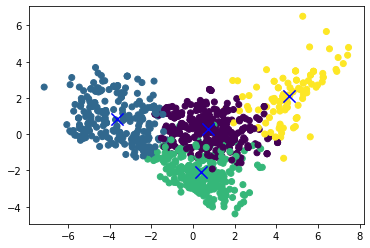

In [197]:
cluster_model_1 = KMeans(n_clusters=4) ## using kmean cluster, to create 5 clusters

# feed the sentence embedding into the clustering model
cluster_model_1.fit(np.asarray(sentence_embeddings))

# reduce the features to 2D
pca = PCA(n_components=2, random_state=42)
reduced_features_1 = pca.fit_transform(np.asarray(sentence_embeddings))

# reduce the cluster centers to 2D
reduced_cluster_centers_1 = pca.transform(cluster_model_1.cluster_centers_)
predict_cluster = cluster_model_1.predict(np.asarray(sentence_embeddings))
## plot clustering
plt.scatter(reduced_features_1[:,0], reduced_features_1[:,1], c=predict_cluster) #
plt.scatter(reduced_cluster_centers_1[:, 0], reduced_cluster_centers_1[:,1], marker='x', s=150, c='b')